In [1]:
import torch
import torch.nn.functional as Fun

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

DTYPE = torch.float32

In [2]:
Fun.softmax(torch.tensor([1,2,3.]), dim=0)


tensor([0.0900, 0.2447, 0.6652])

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
def in_jupyter():
	try:
		get_ipython
		return True
	except NameError:
		return False
if in_jupyter():
	from tqdm.notebook import trange
	from tqdm.notebook import tqdm
else:
	from tqdm import trange
	from tqdm import tqdm

# датасет: cпираль

In [5]:
from sklearn.datasets import make_classification, make_circles, make_moons

def generate_dataset(dataset_type='spiral', n_samples=400, noise=1.3):
    """Генерация различных типов датасетов"""
    if dataset_type == 'circle':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    elif dataset_type == 'xor':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   flip_y=0.1, class_sep=0.5)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset_type == 'spiral':
        n = n_samples // 2
        theta = np.sqrt(np.random.rand(n)) * 4 * np.pi
        r_a = 2 * theta + np.pi
        data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
        x_a = data_a + np.random.normal(0,noise,(n,2))

        theta = np.sqrt(np.random.rand(n)) * 4 * np.pi
        r_b = -2 * theta - np.pi
        data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
        x_b = data_b + np.random.normal(0,noise,(n,2)) * noise

        X = np.vstack([x_a, x_b])
        y = np.hstack([np.zeros(n), np.ones(n)])
    else:  # linear
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1)

    #return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)
    return X, y.reshape(-1, 1)


In [6]:
X,y = generate_dataset(noise=1.3)

In [7]:
type(X)

numpy.ndarray

In [8]:
def foo(grid):
	return np.exp(grid[:,0])+grid[:,0]

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs).detach().cpu().numpy()
	else:
		return model(X)

def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]
x_min, y_min, x_max, y_max

(np.float64(-29.64960960005024),
 np.float64(-28.05790972747146),
 np.float64(31.628302954405484),
 np.float64(29.624150000210843))

# графики на matplotlib

In [9]:
import matplotlib.pyplot as plt
def draw_dots(X,y,ax):
	#X_np, y_np = X.numpy(), y.numpy().flatten()
	X_np, y_np = X, y.flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')



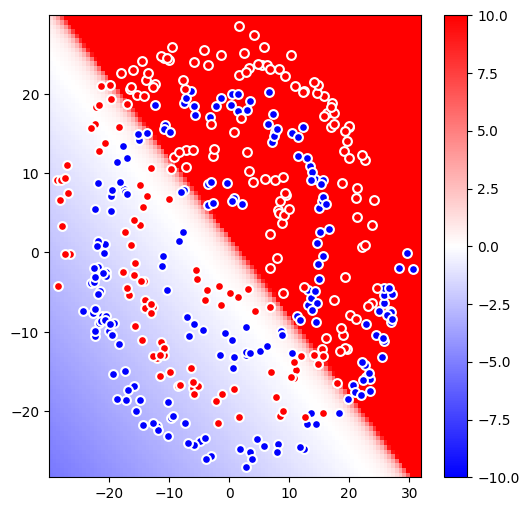

In [10]:
def foo(grid):
	return np.exp(grid[:,0]+grid[:,1]) + grid[:,0]*0.1+grid[:,1]*0.1 + 0.5

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs).detach().cpu().numpy()
	else:
		return model(X)
		
def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]

def draw_mesh(foo, ax, x_min, y_min, x_max, y_max, resolution = 100, cmin=-10, cmax=10):
	xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
	Z = as_numpy(foo,grid)
	norm = mcolors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
	
	return ax.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap='bwr', norm=norm)

fig, ax = plt.subplots(figsize=(6, 6))
tmp = draw_mesh(foo,ax,x_min, y_min, x_max, y_max)
plt.colorbar(tmp, ax=ax)

draw_dots(X,y,ax)

plt.show()

# виджеты

In [11]:
from pathlib import Path
import anywidget
import ipywidgets
from traitlets import Int as tInt, Float as tFloat, Bool as tBool, List as tList
from traitlets import Unicode as tUnicode
import numpy as np

class HeatmapWidget(anywidget.AnyWidget):
	_esm = Path("heatmap.js").read_text(encoding="utf-8")

	height = tInt().tag(sync=True)
	width = tInt().tag(sync=True)
	cell_size = tInt(10).tag(sync=True)
	colormap = tList(tList(tInt())).tag(sync=True)
	#draw_count_request = tInt(0).tag(sync=True)
	#draw_count = tInt(0).tag(sync=True)

	_data = tUnicode("").tag(sync=True)

	def __init__(self, height, width, cell_size=10, colormap=None, zmin=-1, zmid=0, zmax=1):
		super().__init__()
		self.height = height
		self.width = width
		self.cell_size = cell_size
		self.colormap = [[40,136,196],[227,232,234],[245,150,40]] if colormap is None else colormap
		assert zmin<zmid<zmax , f'should be zmin<zmid<zmax: {zmin}<{zmid}<{zmax}'
		self.zmin = zmin
		self.zmid = zmid
		self.zmax = zmax
		#self.draw_call_count = 0
		#self.saved_data = ''
		#self.same_data_count = 0

	def draw(self,arr):
		v = arr.reshape(-1) - self.zmid
		assert len(v) == self.height * self.width, len(v)
		a = 128 / (self.zmid - self.zmin)
		b = 128 / (self.zmax - self.zmid)
		out =  np.clip(np.where(v<=0, v*a, v*b) + 128, 0, 255)
		#data = (out + 100).astype('uint32').tobytes().decode('utf-32-le')
		data = base64.b64encode(out.astype('uint8').tobytes()).decode('ascii')
		#if data==self.saved_data:
		#	self.same_data_count+=1
		#self.saved_data = data
		self._data = data
		#self.draw_call_count += 1
		#return data


In [15]:
class PingWidget(anywidget.AnyWidget):
	_esm = '''
function render({ model, el }) {
	model.on("change:ping", () => {
		model.set("pong",model.get("ping"))
		model.save_changes();
	});
}
export default { render }
'''
	ping = tBool().tag(sync=True)
	pong = tBool().tag(sync=True)


In [16]:
ping = PingWidget()
l1 = ipywidgets.Label(value='ня')
l2 = ipywidgets.Label(value='ня')
ipywidgets.HBox([l1,ping,l2])

In [17]:
ping.ping = not ping.ping
ping.ping

True

In [18]:
ping.pong

True

In [20]:
ping.ping = not ping.ping
ping.pong


False

In [21]:
h, w = 1, 150
wgt = HeatmapWidget(height=h, width=w, cell_size=4)
wgt.draw(np.linspace(-1,1,150))
wgt

In [22]:
h, w = 50, 150
wgt = HeatmapWidget(height=h, width=w, cell_size=4)
wgt.draw(np.random.rand(h, w)*2-1)
wgt

In [23]:
import time
skipped = 0
t0 = time.time()
t1 = time.time()
N=200
i=0
while i<N:
	if time.time()-t1>0.03:
		if i%60==0:
			while ping.ping!=ping.pong:
				time.sleep(0.07)
				skipped +=1
			ping.ping = not ping.ping
		wgt.draw(np.random.rand(h, w)*2-1)
		t1 = time.time()
		i+=1
	time.sleep(0.005)
skipped, N/(time.time()-t0)

(0, 31.078157939769724)

In [24]:
#%timeit wgt.draw(np.random.rand(h, w)*2-1)

import time
skipped = 0
t0 = time.time()
t1 = time.time()
N=200
i=0
dt = 0.03
while i<N:
	if time.time()-t1>dt:
		if i%30==0:
			if ping.ping!=ping.pong:
				if dt<1: dt *= 2
				time.sleep(0.01)
				print(i,dt)
			ping.ping = not ping.ping
		if dt>0.02: dt /= 1.001
		wgt.draw(np.random.rand(h, w)*2-1)
		t1 = time.time()
		i+=1
	time.sleep(0.005)
skipped, N/(time.time()-t0)

(0, 32.100966984933535)

In [25]:
#%timeit wgt.draw(np.random.rand(h, w)*2-1)

import time
skipped = 0
t0 = time.time()
N=300
for i in range(N):
	wgt.draw(np.random.rand(h, w)*2-1)
	time.sleep(0.03)
skipped, N/(time.time()-t0)

(0, 31.803042680017146)

In [26]:
X.shape, y.shape

((400, 2), (400, 1))

In [27]:
class HeatmapWithPoints(HeatmapWidget):
	_esm = Path("heatmap_with_points.js").read_text(encoding="utf-8")

	# просто держим пустую модель (на будущее можно добавить атрибуты)
	points = tList(tList(tFloat())).tag(sync=True)
	bb = tList(tFloat(), default_value=[0, 0, 1, 1]).tag(sync=True)
	def __init__(self, *args, points=None, bb=None, **kwargs):
		super().__init__(*args, **kwargs)
		self.points = [] if points is None else points
		self.bb = bb if bb is not None else [0, 0, 1, 1]
	def _clipz(self,c):
		if c<self.zmid:
			if c<self.zmin: return 0
			else: return int(128-(c-self.zmid)/(self.zmin-self.zmid)*128)
		else:
			if c>self.zmax: return 255
			else: return int(128+(c-self.zmid)/(self.zmax-self.zmid)*128)
	def draw_points(self,X,z):# slow function
		self.points = [(float(a),float(b),self._clipz(c)) for ((a,b),(c,)) in zip(X,y)]

In [28]:
w = HeatmapWithPoints(width=5, height=5, cell_size=100, bb=[0, 0, 100, 200])
w

In [29]:
w.points = [
	[1,   0,   255],	# левый нижний угол
	[100, 200, 0],		# правый верхний угол
	[50,  100, 128],	# центр
]

In [30]:
w.draw(np.random.randn(5, 5))

In [31]:
w.cell_size = 40

In [32]:
w = HeatmapWithPoints(height=50, width=50, cell_size=8, bb=[0,0,50,50])

# фон
w.draw(np.random.randn(50,50))

# точки
w.points = [
	[10, 10, 255],
	[20, 15, 128],
	[40, 35,   0],
]

w

In [33]:
w.draw(np.random.randn(50,50))

In [34]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs).detach().cpu().numpy()
	else:
		return model(X)

def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]

def draw_mesh(foo, wgt, x_min, y_min, x_max, y_max, resolution = 100, cmin=-10, cmax=10):
	xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
	Z = as_numpy(foo,grid)
	wgt.draw(Z.reshape(xx.shape))

w = HeatmapWithPoints(height=100, width=100, cell_size=4, bb=[x_min,y_min,x_max,y_max],zmin=0,zmid=0.5,zmax=1)
draw_mesh(foo,w,x_min, y_min, x_max, y_max)
w.draw_points(X,y)
w

In [35]:
class HistoryPlot(anywidget.AnyWidget):
	_esm = Path("history_plot.js").read_text(encoding="utf-8")

	_new_x = tInt(-1).tag(sync=True)
	_new_y = tFloat(0.0).tag(sync=True)

	maxlen = tInt().tag(sync=True)
	width = tInt().tag(sync=True)
	height = tInt().tag(sync=True)
	logmode = tBool().tag(sync=True)
	title = tUnicode("").tag(sync=True) # title in 13 symbols

	def __init__(self, maxlen=1500, width = 500, height = 100, title=''):
		super().__init__()
		self._counter = 0
		self.maxlen = maxlen
		self.width = width
		self.height = height
		self.title = title

	def update(self, value: float):
		self._new_y = float(value)
		self._new_x = self._counter # триггер обновления, должен быть после обновления _new_y
		self._counter += 1

	def skip(self):
		self._counter += 1


In [36]:
plot = HistoryPlot(title='abcdefghijklmnopqrs')
plot

In [37]:

for y1 in np.random.rand(200)*2-1:
	plot.update(y1)
	time.sleep(0.03)

In [38]:
plot = HistoryPlot(maxlen=5)
plot

In [39]:
plot.update(3.141111111)

In [40]:
plot.update(2.0)

In [41]:
plot.update(100)

In [42]:
plot.logmode = True

In [43]:
plot

In [44]:
plot.update(1)

In [45]:
plot.skip()

In [46]:
plot.update(3)

In [47]:
plot.update(2)

In [48]:
plot.update(5)

In [49]:
plot.update(4)

In [50]:
plot.update(4)

In [51]:
plot.update(4)

In [52]:
plot.update(4)

In [53]:
plot.update(4)

# модель на виджетах

In [54]:
import torch.nn as nn
import ipywidgets

In [55]:
def kaiming_name(foo):
	#kaiming_uniform_nonlins = ['linear', 'conv1d', 'conv2d', 'conv3d', 'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d',
	#	'sigmoid', 'tanh', 'relu', 'leaky_relu', 'selu']
	KAIMING_NONLIN_MAP = {'function':'linear',
	'hardshrink':'linear',
	'tanhshrink':'linear',
	'softshrink':'linear',
	'tanh':'tanh',
	'hardtanh':'tanh',
	'sigmoid':'sigmoid',
	'hardsigmoid':'sigmoid',
	'gumbel_softmax':'sigmoid',
	'relu6':'sigmoid',
	'relu':'relu',
	'selu':'selu',
	'hardswish':'leaky_relu',
	'leaky_relu':'leaky_relu',
	'leakyrelu':'leaky_relu',
	'rrelu':'leaky_relu',
	'gelu':'leaky_relu',
	'elu':'leaky_relu',
	'celu':'leaky_relu',
	'softplus':'leaky_relu',
	'logsigmoid':'leaky_relu',
	'silu':'leaky_relu',
	'mish':'leaky_relu',
	}
	inp = foo.__class__.__name__.lower()
	outp = KAIMING_NONLIN_MAP.get(inp,'leaky_relu')
	print(f'kaiming_uniform: for "{inp}" use "{outp}"')
	return outp
kaiming_name(lambda x: x)
kaiming_name(nn.ReLU())

kaiming_uniform: for "function" use "linear"
kaiming_uniform: for "relu" use "relu"


'relu'

In [56]:
import math
class FeedForward(torch.nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation=None, dtype=DTYPE, generator = None, kaiming=None):
		if activation is None: activation = lambda x: x
		if generator is None:
			generator = torch.Generator().manual_seed(int(torch.randint(0,10**10,[1])[0]))
		if kaiming is None:
			kaiming = kaiming_name(activation)
		super(FeedForward, self).__init__()

		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation

		prev_size = input_size

		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size, dtype=dtype))
			nn.init.kaiming_uniform_(self.layers[-1].weight, nonlinearity=kaiming, generator=generator)
			bound = 1 / math.sqrt(prev_size)
			self.layers[-1].bias.data.uniform_(-bound,bound, generator=generator)
			self.activations.append(activation)
			prev_size = hidden_size

		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		nn.init.kaiming_uniform_(self.layers[-1].weight, nonlinearity='sigmoid', generator=generator)
		bound = 1 / math.sqrt(prev_size)
		self.layers[-1].bias.data.uniform_(-bound,bound, generator=generator)
		self.activations.append(nn.Sigmoid())

		# Для хранения промежуточных значений во время отрисовки состояния
		self.layer_outputs = []
		self.can_draw = 0
		# 0 - no data
		# 1 - has data, no axes
		# 2 - has data, has_axes
		self.drawing = False

	def forward(self, X):
		if self.drawing:
			self.layer_outputs = []
		for i, (layer, activation) in enumerate(zip(self.layers, self.activations)):
			X = activation(layer(X))
			if self.drawing:
				self.layer_outputs.append(X.detach().clone())

		return X

	# __DRAW_INTERFACE__
	def init_draw(self,X):
		self.layer_outputs = []
		self.resolution = 30
		self.x_min, self.x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
		self.y_min, self.y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
		self.xx, self.yy, self.grid = calc_mesh(
			self.x_min, self.y_min, self.x_max, self.y_max, resolution = self.resolution)
		mp = next(self.parameters())
		self.grid = torch.tensor(self.grid, dtype=mp.dtype, device=mp.device)
		self.can_draw = 1

	def calc_draw(self):
		self.drawing = True
		with torch.no_grad():
			tmp = self.forward(self.grid)
		self.drawing = False
		return tmp

	def draw_layers(self):
		assert self.can_draw >=1
		self.can_draw = 2
		self.widgets = []
		for ln in range(len(self.layers)-1):
			l_widgets = []
			for nn in range(self.layers[ln].out_features):
				widget = HeatmapWidget(self.resolution, self.resolution, cell_size=2, zmin=-2, zmid=0, zmax=2)
				widget.draw(self.layer_outputs[ln][:,nn].cpu())
				l_widgets.append(widget)
			self.widgets.append(ipywidgets.VBox(l_widgets))
		self.widgets = ipywidgets.HBox(self.widgets)
		return self.widgets

	def redraw_layers(self):
		assert self.can_draw >=2, self.can_draw
		for ln in range(len(self.layers)-1):
			for nn in range(self.layers[ln].out_features):
				Z = self.layer_outputs[ln][:,nn].cpu()
				self.widgets.children[ln].children[nn].draw(Z.reshape(self.xx.shape))

	def draw(self):
		self.out_resolution = 80
		self.out_xx, self.out_yy, self.out_grid = calc_mesh(
			self.x_min, self.y_min, self.x_max, self.y_max, resolution = self.out_resolution)
		mp = next(self.parameters())
		self.out_grid = torch.tensor(self.out_grid, dtype=mp.dtype, device=mp.device)
		with torch.no_grad():
			Z = self.forward(self.out_grid).cpu()
		self.out_wgt = HeatmapWithPoints(
			height=self.out_resolution, width=self.out_resolution, cell_size=4, bb=[x_min,y_min,x_max,y_max],zmin=0,zmid=0.5,zmax=1)
		self.out_wgt.draw(Z.reshape(self.out_xx.shape))
		return self.out_wgt

	def redraw(self):
		with torch.no_grad():
			Z = self.forward(self.out_grid).cpu()
		self.out_wgt.draw(Z.reshape(self.out_xx.shape))
		return self.out_wgt


# учим онлайн на виджетах

In [57]:
type(X), X.shape, type(y), y.shape

(numpy.ndarray, (400, 2), numpy.ndarray, (400, 1))

In [58]:
import threading
import sys
import time
import hashlib

def print_weights(m):
	print(type(m),m)
	if type(m) is nn.Linear:
		print(hashlib.sha256(m.weight.detach().numpy().tobytes()).hexdigest())

# === model ===

#model.apply(print_weights)
#print(hashlib.sha256(X.tobytes()).hexdigest())
#print(hashlib.sha256(y.tobytes()).hexdigest())


In [65]:
import traceback

def learn_onlie(model, X, y, criterion,
		optim_type=optim.Adam, # optim.SGD
		optim_params=dict(),
		device='cpu', # 'cuda'
		default_lr=0.001,
		default_bs=16,
		load_gen = None
	):
	if load_gen is None:
		load_gen = torch.Generator().manual_seed(int(torch.randint(0,10**10,[1])[0]))
	# === обновление параметров ===
	logg = ''
	logg_lbl = ipywidgets.HTML(value=logg)
	def log(s):
		nonlocal logg
		logg+=str(s); logg_lbl.value = '<pre>'+logg+'</pre>'

	learning_rate = default_lr
	lr_changed = True
	optimizer = None
	def update_learning_rate():
		nonlocal optimizer
		optimizer = optim_type(model.parameters(), lr=learning_rate, **optim_params)
		#optimizer = (model.parameters(), lr=learning_rate)
		nonlocal lr_changed
		lr_changed = False

	train_set = TensorDataset(torch.tensor(X, dtype=DTYPE, device=device), torch.tensor(y, dtype=DTYPE, device=device))
#	print(hashlib.sha256(train_set.numpy().tobytes()).hexdigest())
	model.to(device)
	batch_size = default_bs
	bs_changed = True
	loader = None
	def update_batch_size():
		nonlocal loader
		loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=load_gen)
		# suffle происходит при каждом вызове iter()/for
		nonlocal bs_changed
		bs_changed = False

	loss_history = []
	lr_history = []
	bs_history = []

	need_reset_prof = True
	prof_total = 0
	prof_calc_draw = 0
	prof_draw = 0
	prof_forward = 0
	prof_backward = 0
	prof_step = 0
	prof_cnt = 0
	prof_draw_cnt = 0

	# === отрисовка ===
	model.init_draw(X)
	model.calc_draw()
	layers_output = model.draw_layers()
	main_heatmap = model.draw()
	main_heatmap.draw_points(X,y)

	prof_lbl = ipywidgets.HTML(value='.')
	info_lbl = ipywidgets.Label(value='ня ня ня')
	loss_wgt = HistoryPlot(title='loss')
	lr_wgt = HistoryPlot(title='lr')
	bs_wgt = HistoryPlot(title='bs')
	ping = PingWidget()

	def redraw():
		t0 = time.time()
		model.calc_draw()
		t1 = time.time()
		model.redraw_layers()
		model.redraw()
		info_lbl.value = f"x:[{model.x_min:5.4}..{model.x_max:5.4}] ; y:[{model.y_min:5.4} .. {model.y_max:5.4}] ; "+\
			f"epoch={len(loss_history)} ; loss={loss_history[-1] if len(loss_history)>0 else '':.4}"

		t2 = time.time()

		return (t1-t0, t2-t1)

	update_learning_rate()
	update_batch_size()
	redraw()

	# === обучение ===
	running = False
	def learn():
		try:
			nonlocal logg, prof_total, prof_calc_draw, prof_draw, prof_forward, prof_backward
			nonlocal prof_step, prof_cnt, prof_draw_cnt, need_reset_prof
			logg = 'start-'
			log('')

			draw_t0 = time.time()
			prof_t0 = time.time()
			#print('start')
			while running:
				if lr_changed: update_learning_rate()
				if bs_changed: update_batch_size()
				if need_reset_prof:
					prof_t0 = time.time()
					prof_total = 0
					prof_calc_draw = 0
					prof_draw = 0
					prof_forward = 0
					prof_backward = 0
					prof_step = 0
					prof_cnt = 0
					prof_draw_cnt = 0
					need_reset_prof = False

				mean_loss = 0
				n_batch = 0
				for X,y in loader:
					prof_t2 = time.time()
					loss = criterion(model(X), y)
					prof_t3 = time.time()
					optimizer.zero_grad()
					prof_t4 = time.time()
					loss.backward()
					prof_t5 = time.time()
					optimizer.step()
					prof_t6 = time.time()

					prof_forward+= (prof_t3 - prof_t2)
					prof_backward+= (prof_t5 - prof_t4)
					prof_step+= (prof_t6 - prof_t5)
					mean_loss += loss.item()
					n_batch +=1

				prof_cnt +=1
				loss_history.append(mean_loss/n_batch)
				lr_history.append(optimizer.param_groups[0]['lr'])
				bs_history.append(loader.batch_size)

				if time.time() - draw_t0 > 0.03:
					if prof_draw_cnt%20==0:
						while ping.ping!=ping.pong:
							time.sleep(0.07)
						ping.ping = not ping.ping
					draw_t0 = time.time()
					a,b = redraw()
					#prof_calc_draw +=a
					prof_draw += a+b
					prof_draw_cnt +=1
					l = prof_cnt
					prof_lbl.value = f"<pre>total:{(prof_total+time.time()-prof_t0)/l*1000:<6.4g} " +\
						f"forward:{prof_forward/l*1000:<6.4g} backward:{prof_backward/l*1000:<6.4g} step:{prof_step/l*1000:<6.4g}"+\
						f" - ms/epoch ; draw:{prof_draw/prof_draw_cnt*1000:<6.4g} - ms/frame"+\
						f"\n{l/(prof_total+time.time()-prof_t0):<6.4g} epoch/s"+\
						f" ; {prof_draw_cnt/(prof_total+time.time()-prof_t0):<6.4g} frame/s </pre>"
					loss_wgt.update(loss_history[-1])
					lr_wgt.update(lr_history[-1])
					bs_wgt.update(bs_history[-1])
				else:
					pass
					loss_wgt.skip()
					lr_wgt.skip()
					bs_wgt.skip()
			redraw()
			prof_total += time.time() - prof_t0
			log('stop\n')
		except Exception:
			log(traceback.format_exc())

	# === управление ===
	#printput = ipywidgets.Output()
	start_stop = ipywidgets.ToggleButton(value=False, description='Старт', icon='play')
	#@printput.capture(clear_output=False)
	def on_toggle(change):
		nonlocal running
		if change['new']:
			start_stop.description = 'Стоп'
			start_stop.icon = 'pause'
			running = True
			threading.Thread(target=learn, daemon=True).start()
		else:
			start_stop.description = 'Старт'
			start_stop.icon = 'play'
			running = False
	start_stop.observe(on_toggle, names='value')

	def f(k): return [10*k,22*k,47*k]
	lr_slider = ipywidgets.SelectionSlider(
		options=f(1e-7)+f(1e-6)+f(1e-5)+f(1e-4)+f(1e-3)+f(1e-2)+f(1e-1)+f(1e0),
		value=learning_rate,
		description='Learning Rate',
		continuous_update=True
	)
	#@printput.capture(clear_output=False)
	def lr_change(change):
		nonlocal learning_rate, lr_changed
		learning_rate = change['new']
		lr_changed = True
	lr_slider.observe(lr_change, names='value')

	bs_slider = ipywidgets.SelectionSlider(
		options=[1,2,4,8,16,32,64,128,256],
		value=batch_size,
		description='Batch size',
		continuous_update=True
	)
	#@printput.capture(clear_output=False)
	def bs_change(change):
		nonlocal batch_size, bs_changed
		batch_size = change['new']
		bs_changed = True
	bs_slider.observe(bs_change, names='value')

	log_box = ipywidgets.Checkbox(description='history log scale')
	def log_change(change):
		loss_wgt.logmode = change['new']
		lr_wgt.logmode = change['new']
		bs_wgt.logmode = change['new']
	log_box.observe(log_change, names='value')

	prof_reset_btn = ipywidgets.Button(description='reset profiling')
	def prof_reset(b):
		nonlocal need_reset_prof
		need_reset_prof = True
	prof_reset_btn.on_click(prof_reset)

	display(
		ipywidgets.HBox([start_stop,lr_slider,bs_slider]),
		#printput,
		ipywidgets.HBox([ping,log_box,info_lbl]),
		ipywidgets.HBox([prof_reset_btn,prof_lbl]),
		logg_lbl,
		loss_wgt,
		lr_wgt,
		bs_wgt,
		ipywidgets.HBox([layers_output,main_heatmap]))

In [67]:
model = FeedForward(2, [5, 5, 5, 5, 5], nn.ReLU(), generator=torch.Generator().manual_seed(43))

g = torch.Generator().manual_seed(43)
learn_onlie(model, X, y, nn.BCELoss(), load_gen=g)

kaiming_uniform: for "relu" use "relu"


HTML(value='')

In [60]:
model2 = FeedForward(2, [5, 5, 5, 5, 5], nn.ReLU(), generator=torch.Generator().manual_seed(43))

g = torch.Generator().manual_seed(43)
learn_onlie(model2, X, y, nn.BCELoss(), load_gen=g)

kaiming_uniform: for "relu" use "relu"


HTML(value='')

In [70]:
lin = nn.Linear(2, 3)
for x in lin.parameters():
	print(type(x),x)

<class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor([[ 0.1377,  0.4822],
        [ 0.3302,  0.6325],
        [ 0.3302, -0.5394]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor([ 0.3497, -0.5506,  0.4730], requires_grad=True)


In [220]:
torch.manual_seed(42)
np.random.seed(42)

g = torch.Generator().manual_seed(42)
#g

In [221]:
torch.randn(2,2,generator=g)

tensor([[0.3367, 0.1288],
        [0.2345, 0.2303]])

In [222]:
torch.randn(2,2,generator=g)

tensor([[-1.1229, -0.1863],
        [ 2.2082, -0.6380]])

In [223]:
loaderg = DataLoader(
	data,
	batch_size=32,
	shuffle=True,
	generator=g
)

In [224]:
h = g.clone_state()

In [225]:
for x in loaderg:
	print('a',end='')

aaaaaaaaaa

In [226]:
torch.randn(2,2,generator=g)

tensor([[-1.4283, -0.3795],
        [ 1.5015,  0.1274]])

In [227]:
torch.randn(2,2,generator=g)

tensor([[ 1.0316, -0.5814],
        [ 0.7994,  0.4884]])

In [228]:
loaderh = DataLoader(
	data,
	batch_size=32,
	shuffle=True,
	generator=h
)

In [229]:
for x in loaderh:
	print('a',end='')

aaaaaaaaaa

In [230]:
torch.randn(2,2,generator=h)

tensor([[-1.4283, -0.3795],
        [ 1.5015,  0.1274]])

In [231]:
torch.randn(2,2,generator=h)

tensor([[ 1.0316, -0.5814],
        [ 0.7994,  0.4884]])

# учим оффлайн

In [74]:
def train_network(X, y, learning_rate=0.001, batch_size=16, epochs=1000, device='cpu'):
	global model
	global loss_history
	global accuracy_history
	model.drawing = True

	"""Обучение нейронной сети с визуализацией"""

	# Функция потерь и оптимизатор
	criterion = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

	# История обучения
	loss_history = []
	accuracy_history = []

	train_set = TensorDataset(torch.tensor(X, dtype=DTYPE).to(device), torch.tensor(y, dtype=DTYPE).to(device))
	loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

	prog_bar = tqdm(range(epochs), total=epochs, desc='start', leave=True)
	for epoch in prog_bar: #trange(epochs):
		mean_loss = 0
		n_batch = 0
		for X,y in loader:
			# Прямой проход
			outputs = model(X)
			loss = criterion(outputs, y)

			# Обратное распространение
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			mean_loss += loss.item()
			n_batch +=1

		# Расчет точности
		#predicted = (outputs > 0.5).float()
		#accuracy = (predicted == y).float().mean()

		loss_history.append(mean_loss/n_batch)
		#accuracy_history.append(accuracy.item())

		desc = f'{epoch} Loss: {mean_loss/n_batch:.4}'
		prog_bar.set_description(desc, refresh=True)

	model.drawing = False


model = FeedForward(2,[20,20,20],nn.ReLU())
train_network(X,y)

start:   0%|          | 0/1000 [00:00<?, ?it/s]

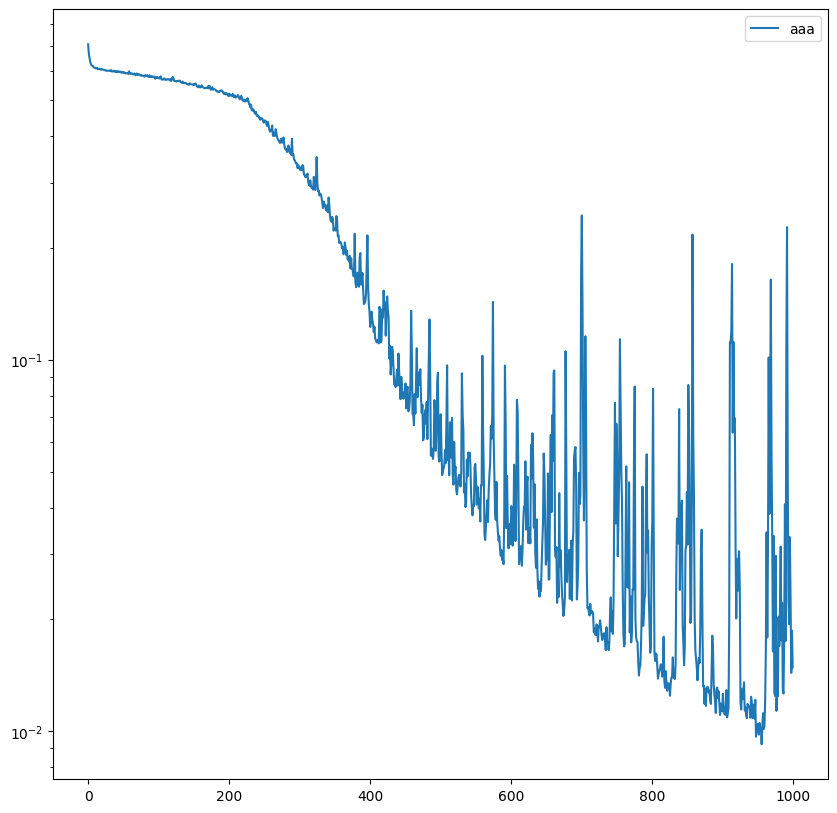

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(loss_history, label='aaa')
plt.yscale("log")
ax.legend()
plt.show()

TypeError: model() missing 3 required positional arguments: 'a', 'b', and 'c'

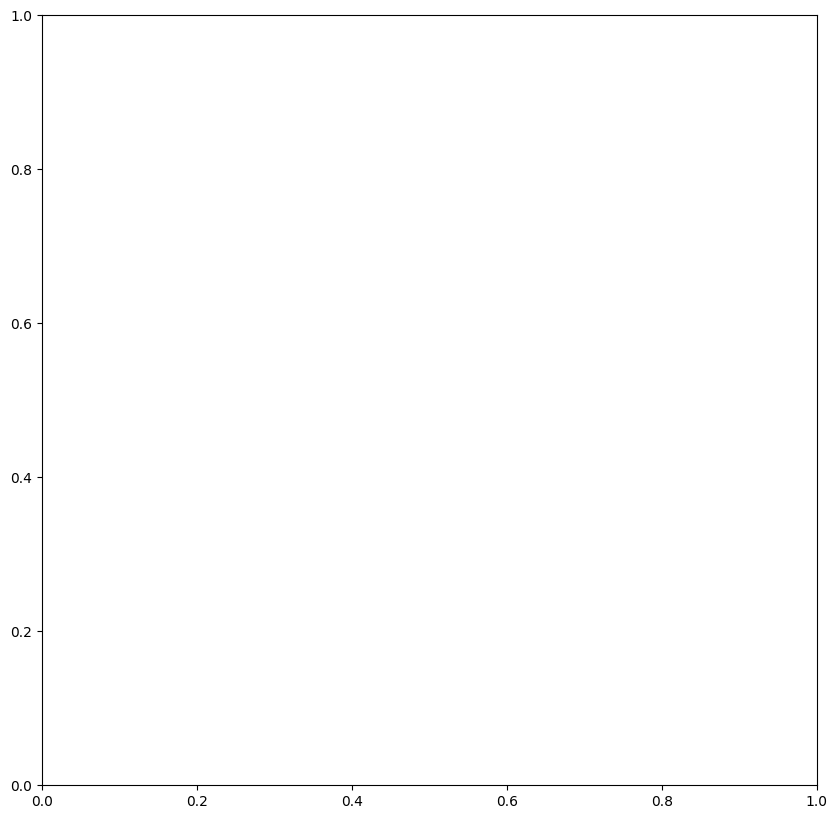

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))
tmp = draw_mesh(model,ax,x_min, y_min, x_max, y_max, cmin=-2, cmax=2)
plt.colorbar(tmp, ax=ax)
#draw_dots(X,y,ax)

plt.show()

# функции активации

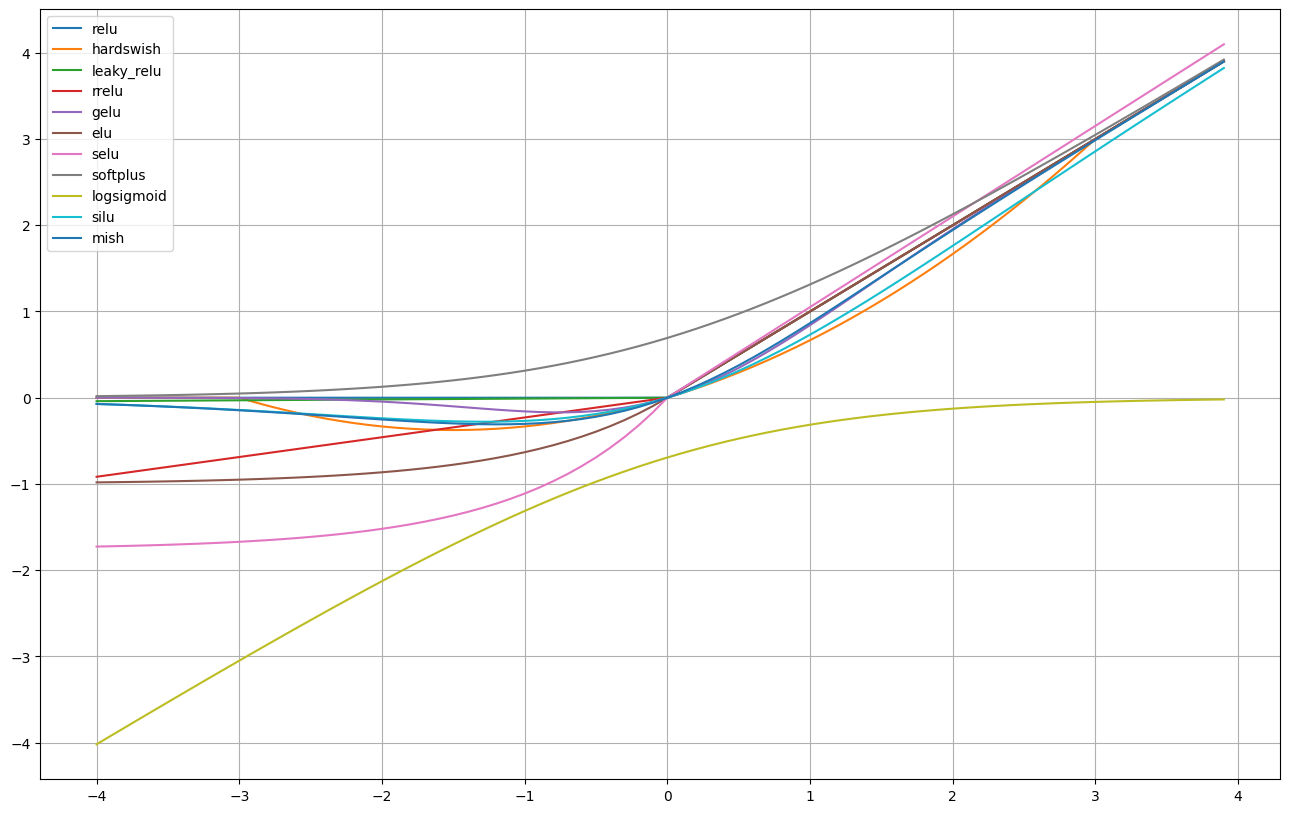

In [77]:
x = torch.arange(-4,4,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

#ax.plot(x,Fun.threshold(x), label='threshold')
#ax.plot(x,Fun.prelu(x), label='prelu')
#ax.plot(x,Fun.glu(x), label='glu')
#ax.plot(x,Fun.softmin(x), label='softmin')
#ax.plot(x,Fun.softmax(x), label='softmax')
#ax.plot(x,Fun.log_softmax(x), label='log_softmax')



ax.plot(x,Fun.relu(x), label='relu')
#ax.plot(x,Fun.hardtanh(x), label='hardtanh')
#ax.plot(x,Fun.relu6(x), label='relu6')
ax.plot(x,Fun.hardswish(x), label='hardswish')
ax.plot(x,Fun.leaky_relu(x), label='leaky_relu')
ax.plot(x,Fun.rrelu(x), label='rrelu')
ax.plot(x,Fun.gelu(x), label='gelu')
ax.plot(x,Fun.elu(x), label='elu') # == #ax.plot(x,Fun.celu(x), label='celu')
ax.plot(x,Fun.selu(x), label='selu')
#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
#ax.plot(x,Fun.hardshrink(x), label='hardshrink')
#ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
#ax.plot(x,Fun.softsign(x), label='softsign')
ax.plot(x,Fun.softplus(x), label='softplus')
#ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
#ax.plot(x,Fun.tanh(x), label='tanh')
#ax.plot(x,Fun.sigmoid(x), label='sigmoid')
#ax.plot(x,Fun.hardsigmoid(x), label='hardsigmoid')
ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
ax.plot(x,Fun.silu(x), label='silu')
ax.plot(x,Fun.mish(x), label='mish')
ax.legend()
ax.grid()
plt.show()

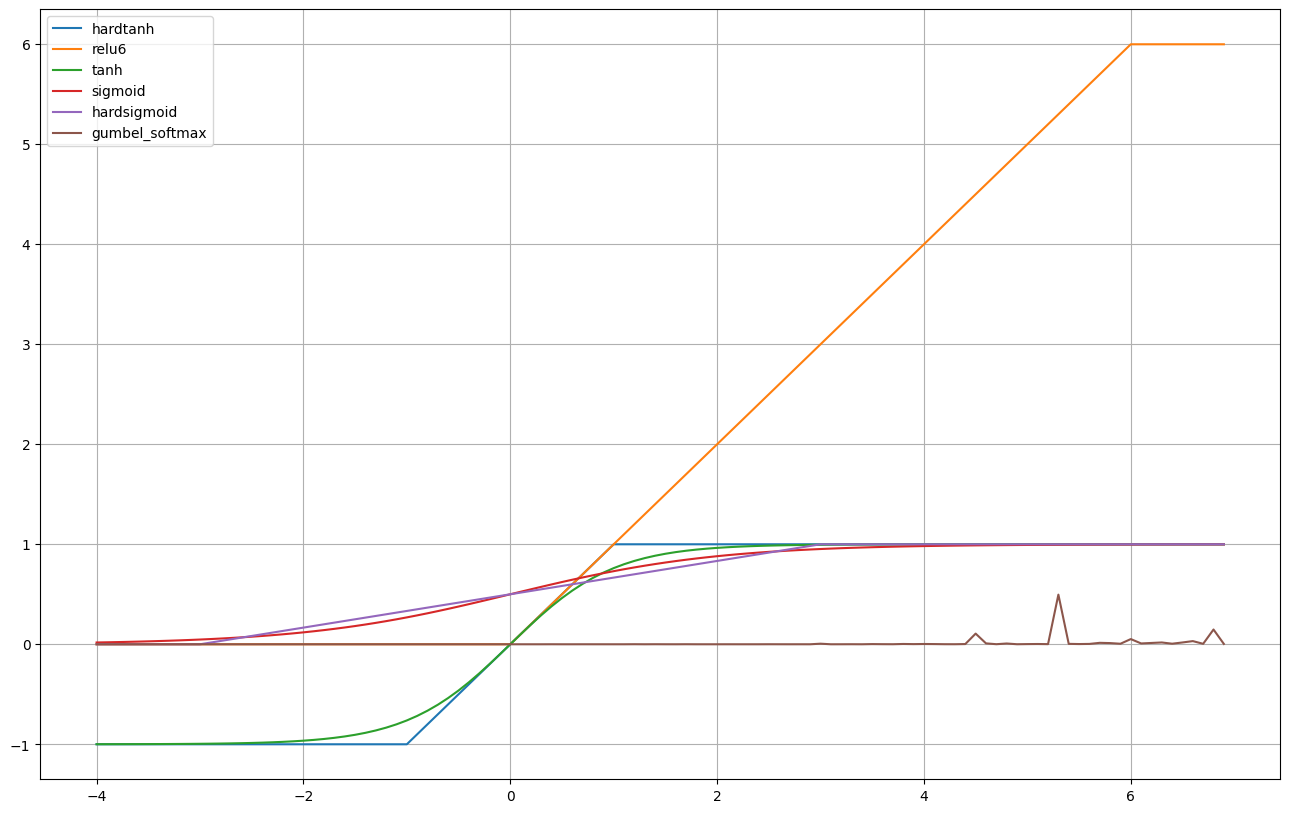

In [78]:
x = torch.arange(-4,7,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(x,Fun.hardtanh(x), label='hardtanh')
ax.plot(x,Fun.relu6(x), label='relu6')
#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
#ax.plot(x,Fun.hardshrink(x), label='hardshrink')
#ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
#ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.plot(x,Fun.tanh(x), label='tanh')
ax.plot(x,Fun.sigmoid(x), label='sigmoid')
ax.plot(x,Fun.hardsigmoid(x), label='hardsigmoid')
ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.legend()
ax.grid()
plt.show()

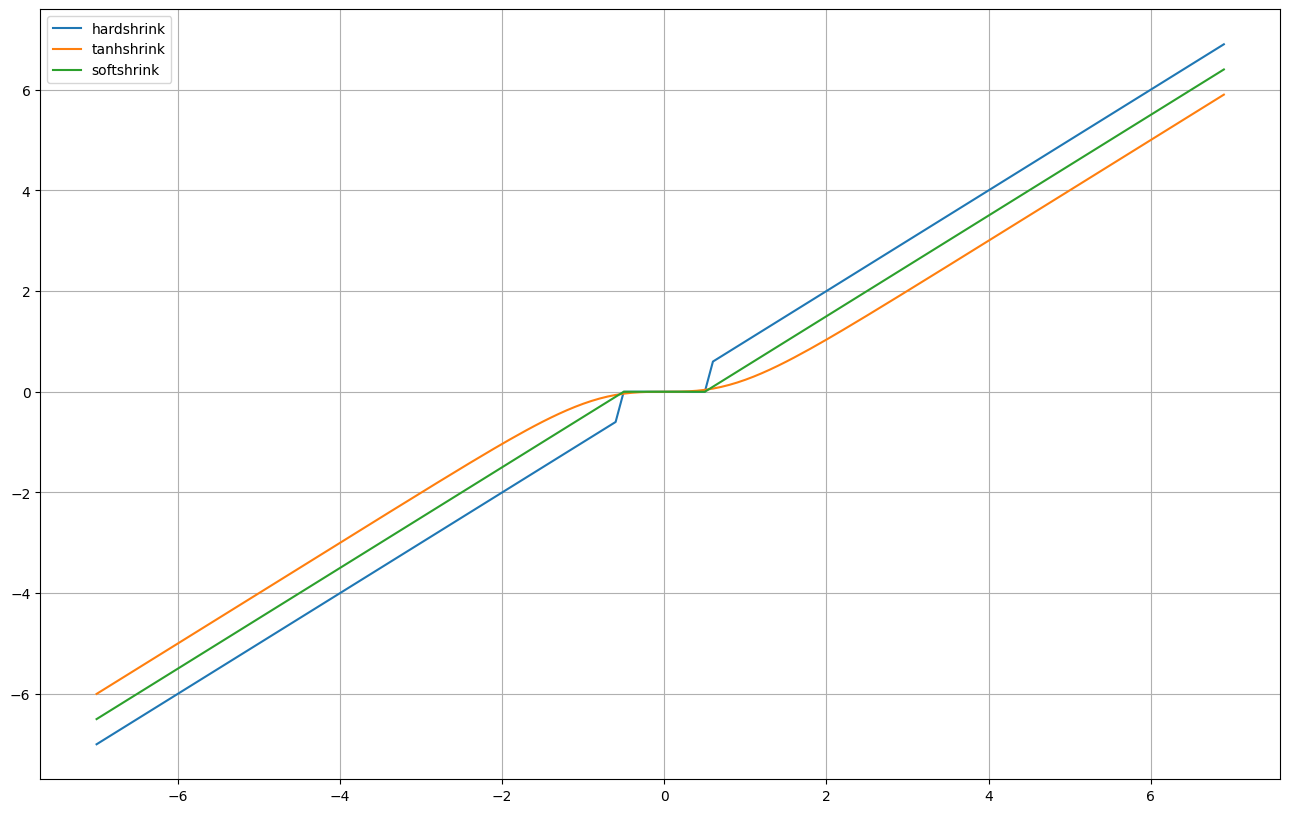

In [79]:
x = torch.arange(-7,7,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
ax.plot(x,Fun.hardshrink(x), label='hardshrink')
ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.legend()
ax.grid()
plt.show()

# backward grad

In [80]:
x = torch.tensor([1.],requires_grad = True)
y = torch.tensor([2.],requires_grad = True)
z = torch.tensor([3.],requires_grad = True)

f = (x+y)*(y-z)
f

tensor([-3.], grad_fn=<MulBackward0>)

In [81]:
f.backward()
x.grad, y.grad, z.grad

(tensor([-1.]), tensor([2.]), tensor([-3.]))

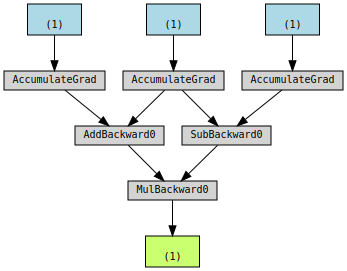

In [83]:
from torchviz import make_dot
make_dot(f)

# Пример задачи регрессии 3 параметра

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

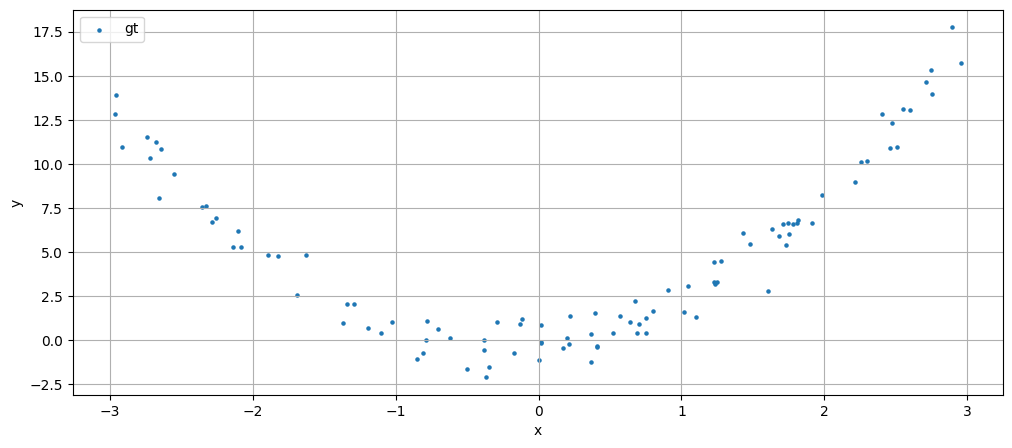

In [85]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 100

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs ** 2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [86]:
def model(x, a, b, c):
    return a * x ** 2 + b * x + c

In [87]:
device = torch.device("cuda")
#device = torch.device("cpu")

In [88]:
# YOUR CODE HERE
xs_device = torch.tensor(xs, device=device, requires_grad=False)
ys_device = torch.tensor(ys, device=device, requires_grad=False)
# END OF YOUR CODE

In [89]:
# YOUR CODE HERE
a = torch.randn(1, device=device, requires_grad=True)
b = torch.randn(1, device=device, requires_grad=True)
c = torch.randn(1, device=device, requires_grad=True)
# END OF YOUR CODE

In [90]:
num_epochs = 300
lr = 1e-4
indices = np.arange(len(xs))

loss_list, ys_pred_per_epoch = [], []


for epoch in trange(num_epochs):
    np.random.shuffle(indices)

    mean_loss = 0.
    for i in indices:
        # YOUR CODE HERE
        x      = xs_device[i]
        y_true = ys_device[i]
        y_pred = model(x,a,b,c)
        loss = (y_true - y_pred)**2
        loss.backward()
        # END OF YOUR CODE
        
        with torch.no_grad():
            #a.data -= lr * a.grad.data
            #b.data -= lr * b.grad.data
            #c.data -= lr * c.grad.data
            a -= lr * a.grad
            b -= lr * b.grad
            c -= lr * c.grad
            a.grad.zero_()
            b.grad.zero_()
            c.grad.zero_()
            
        mean_loss += loss.item()
		
        
    loss_list.append(mean_loss/len(xs))


  0%|          | 0/300 [00:00<?, ?it/s]

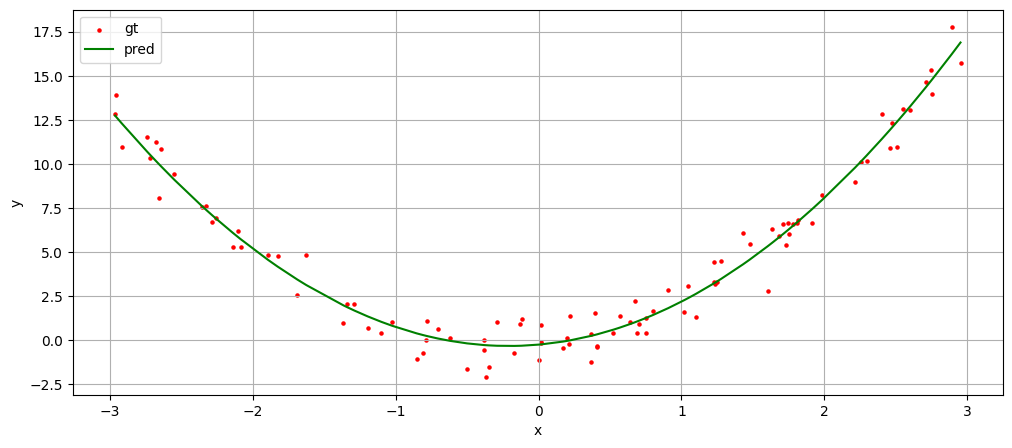

In [91]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5, c="r")

xs_sorted = np.sort(xs)
with torch.no_grad():
	ys_pred = model(xs_sorted, a.item(), b.item(), c.item())

plt.plot(xs_sorted, ys_pred, label="pred", c="g")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

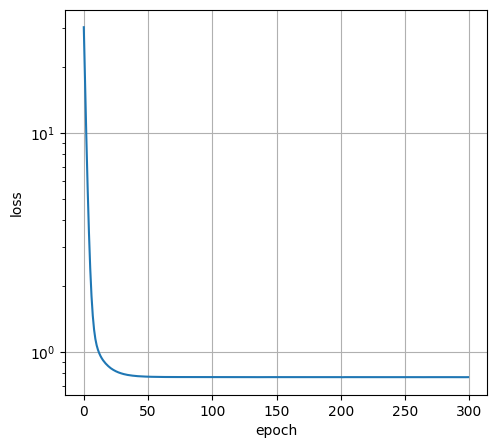

In [92]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.yscale("log")

plt.show()

# colormaps

In [93]:
from plotly.colors import get_colorscale
import colorsys
import re
for x,c in get_colorscale('RdBu_r'):
	o = re.match(r'rgb\((\d*),(\d*),(\d*)\)',c)
	hls = colorsys.rgb_to_hls(int(o.group(1))/255,int(o.group(2))/255,int(o.group(3))/255)
	hsv = colorsys.rgb_to_hsv(int(o.group(1))/255,int(o.group(2))/255,int(o.group(3))/255)
	print(f'{x:3.1f} {c:16}   {hls[0]:.2f} {hls[2]:5.3} {hls[1]:5.3}    {hsv[0]:5.2} {hsv[1]:5.3} {hsv[2]:5.3}')

0.0 rgb(5,48,97)       0.59 0.902   0.2     0.59 0.948  0.38
0.1 rgb(33,102,172)    0.58 0.678 0.402     0.58 0.808 0.675
0.2 rgb(67,147,195)    0.56 0.516 0.514     0.56 0.656 0.765
0.3 rgb(146,197,222)   0.55 0.535 0.722     0.55 0.342 0.871
0.4 rgb(209,229,240)   0.56 0.508  0.88     0.56 0.129 0.941
0.5 rgb(247,247,247)   0.00   0.0 0.969      0.0   0.0 0.969
0.6 rgb(253,219,199)   0.06 0.931 0.886    0.062 0.213 0.992
0.7 rgb(244,165,130)   0.05 0.838 0.733    0.051 0.467 0.957
0.8 rgb(214,96,77)     0.02 0.626 0.571    0.023  0.64 0.839
0.9 rgb(178,24,43)     0.98 0.762 0.396     0.98 0.865 0.698
1.0 rgb(103,0,31)      0.95   1.0 0.202     0.95   1.0 0.404


In [94]:
print(f'{247.:.3}')

2.47e+02


In [95]:
re.match('a.*','asdf')

<re.Match object; span=(0, 4), match='asdf'>

In [96]:
rb,gb,bb = 5,48,97
rw,gw,bw = 247,247,247
rr,gr,br = 103,0,31

rd,gd,bd = (rw-rb)/5, (gw-gb)/5, (bw-bb)/5
for i in range(5):
	print(i, int(rb+rd*i), int(gb+gd*i), int(bb+bd*i))

rd,gd,bd = (rr-rw)/5, (gr-gw)/5, (br-bw)/5
for i in range(5):
	print(i, int(rw+rd*i), int(gw+gd*i), int(bw+bd*i))

0 5 48 97
1 53 87 127
2 101 127 157
3 150 167 187
4 198 207 217
0 247 247 247
1 218 197 203
2 189 148 160
3 160 98 117
4 131 49 74


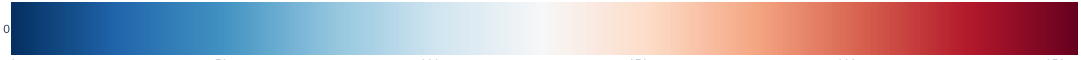

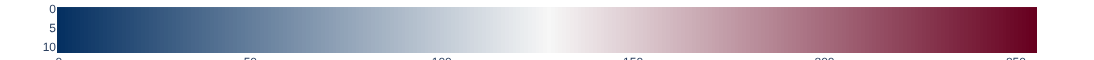

In [97]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()
fig.add_trace(go.Heatmap(
	z=np.linspace(-10,10,256).reshape(1,256),
	zmin=-10, zmid=0, zmax=10,
	colorscale = 'RdBu_r',showscale=False
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()

fig = go.Figure()
r = np.hstack([np.linspace(5,247,129)[:-1],np.linspace(247,103,128)])
g = np.hstack([np.linspace(48,247,129)[:-1],np.linspace(247,0,128)])
b = np.hstack([np.linspace(97,247,129)[:-1],np.linspace(247,31,128)])
c = np.vstack([r,g,b]).T.astype('u8').reshape(1,256,3)
c = np.vstack([c,c,c,c,c,c,c,c,c,c,c,c])
fig.add_trace(go.Image(	z=c))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()





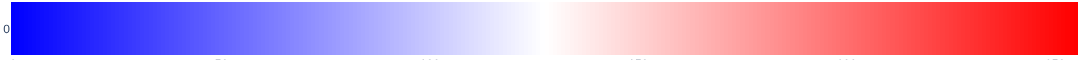

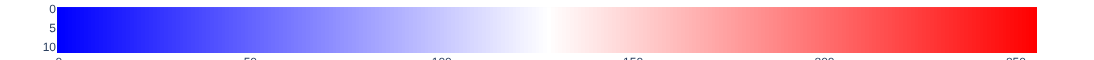

In [98]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()
fig.add_trace(go.Heatmap(
	z=np.linspace(-10,10,256).reshape(1,256),
	zmin=-10, zmid=0, zmax=10,
	colorscale = [[0.0, 'rgb(0,0,255)'],
 [0.5, 'rgb(255,255,255)'],
 [1.0, 'rgb(255,0,0)']],showscale=False
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()

fig = go.Figure()
r = np.hstack([np.linspace(0  ,255,129)[:-1],np.linspace(255,255,128)])
g = np.hstack([np.linspace(0  ,255,129)[:-1],np.linspace(255,0,128)])
b = np.hstack([np.linspace(255,255,129)[:-1],np.linspace(255,0,128)])
c = np.vstack([r,g,b]).T.astype('u8').reshape(1,256,3)
c = np.vstack([c,c,c,c,c,c,c,c,c,c,c,c])
fig.add_trace(go.Image(	z=c))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()





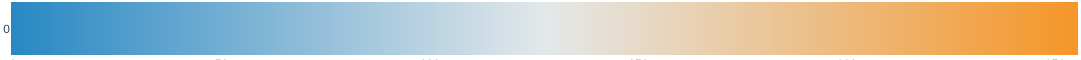

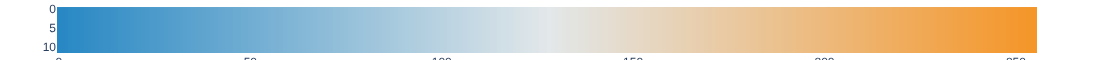

In [99]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
fig = go.Figure()
fig.add_trace(go.Heatmap(
	z=np.linspace(-10,10,256).reshape(1,256),
	zmin=-10, zmid=0, zmax=10,
	colorscale = [[0.0, 'rgb(40,136,196)'],
 [0.5, 'rgb(227,232,234)'],
 [1.0, 'rgb(245,150,40)']],showscale=False
		#get_colorscale('RdBu')[::-1],
		#[	[0.0, 'blue'],	[0.5, 'white'],	[1.0, 'red'],],
))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()

fig = go.Figure()
r = np.hstack([np.linspace(40 ,227,129)[:-1],np.linspace(227,245,128)])
g = np.hstack([np.linspace(136,232,129)[:-1],np.linspace(232,150,128)])
b = np.hstack([np.linspace(196,234,129)[:-1],np.linspace(234,40,128)])
c = np.vstack([r,g,b]).T.astype('u8').reshape(1,256,3)
c = np.vstack([c,c,c,c,c,c,c,c,c,c,c,c])
fig.add_trace(go.Image(	z=c))
fig.update_layout(margin=dict(l=3,r=3,t=3,b=3), width=1000, height=60)
fig.show()





In [100]:
mycolormap_ipw = [[40,136,196],[227,232,234],[245,150,40]]